# Setup

Install required packages (only needed once per environment).  
Packages used:

- `transformers` (Hugging Face) for pretrained models and pipelines
- `torch` as backend for Transformer models
- `pandas`, `numpy` for data wrangling
- `scikit-learn` for metrics and train/test split
- `matplotlib` for plots


In [12]:
!pip install --upgrade pip
!pip install numpy pandas matplotlib scikit-learn transformers torch --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


In [13]:
import os, re, math, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from transformers import pipeline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Path to  dataset file
DATA_PATH = "archive (5)/smile-annotations-final.csv"

print("Using data file:", DATA_PATH)

Using data file: archive (5)/smile-annotations-final.csv


# Load Data & Quick EDA

Load the SMILE dataset, show basic info, and preview a few rows to understand columns.


In [14]:
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nHead:")
display(df.head(10))

Shape: (3084, 3)

Columns: ['611857364396965889', '@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap', 'nocode']

Head:


,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap,nocode
0,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
1,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
2,614877582664835073,@Sofabsports thank you for following me back. ...,happy
3,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy
4,611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy
5,614456889863208960,"@britishmuseum say wot, mate?",nocode
6,614016385442807809,Two workshops on evaluating audience engagemen...,nocode
7,610916556751642624,"A Forest Road, by Thomas Gainsborough 1750 Oil...",nocode
8,614499696015503361,Lucky @FitzMuseum_UK! Good luck @MirandaStearn...,happy
9,612869223354925056,"""1...2..."" ""non arrête mon brush!"". l.Alma|A f...",nocode


# Autodetection of Columns 

In [ ]:

# Attempt to auto-detect text and label columns 
possible_text_cols = [c for c in df.columns if re.search(r"(text|tweet|content|sentence)", c, re.I)]
possible_label_cols = [c for c in df.columns if re.search(r"(label|sentiment|emotion|class|category)", c, re.I)]

text_col  = possible_text_cols[0] if possible_text_cols else df.columns[0]
label_col = possible_label_cols[0] if possible_label_cols else df.columns[1]

print(f"\nAuto-detected text column: {text_col}")
print(f"Auto-detected label column: {label_col}")

# Drop NANs and keep only necessary columns
df = df[[text_col, label_col]].dropna().rename(columns={text_col:"text", label_col:"label"}).reset_index(drop=True)

print("\nUnique labels:", sorted(df['label'].astype(str).unique().tolist()))
print("\nSample rows after renaming:")
display(df.sample(5, random_state=RANDOM_SEED))


Auto-detected text column: 611857364396965889
Auto-detected label column: @aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap

Unique labels: ['"1...2..." "non arrête mon brush!". l.Alma|A favourite custom|1909 @NationalGallery #bonlundi http://t.co/HpjvSJHGhP', '"@Cambscene: Watercolour - Elements of Nature opens @FitzMuseum_UK  🎨☔️⛅️ http://t.co/XaK5ArzBTI" Is this by Samuel Palmer?', '"@CharleJHuguenin: Parmi les grandes neiges de #Monet @nationalgallery http://t.co/yLTs4ovvlv"  Me gusta.', '"@britishmuseum: Ancient Egyptians placed amulets onto mummies to harness supernatural powers  They have this eye everywhere.', '"@britishmuseum: James VI (Scotland) and I (England). His portrait is in this jewel  What is the meaning of "R"?', '"@britishmuseum: Peter Paul Rubens was born #OTD in 1577. http://t.co/2JplC1xL5V http://t.co/ZA5mSyLETi" #SundayArtExchange @MarthaPlimpton', '"@britishmuseum: We’re here with #Bonaparte What about the importance of Napoleon and

,text,label
1505,614391014967672832,Year 4 @britishmuseum checking out some Ancien...
2398,613679581602648064,@DavidSmithArt @roshvarosha @LisaLooly @newman...
1814,614070877597118464,Start your @_TheWhitechapel #FirstThursday at ...
511,613000014374248448,Project curator sought for South Africa exhibi...
1565,614359996822876161,See all the photos from Wednesday's #Defeating...


# Preprocess: Clean Text & Map Emotions → Sentiment

Clean the text (lowercase, strip URLs/mentions/hashtags), then **map fine-grained emotions** to **positive/negative/neutral**.  
If the dataset already has `positive/negative/neutral`, the mapping will keep them as-is.


## Clean text

In [16]:
URL_RE = re.compile(r"http\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
MULTISPACE_RE = re.compile(r"\s+")

def clean_text(s: str) -> str:
    s = s.lower()
    s = URL_RE.sub("", s)
    s = MENTION_RE.sub("", s)
    s = HASHTAG_RE.sub(r"\1", s)  # keep hashtag word
    s = re.sub(r"[^\x00-\x7F]+", " ", s)  # drop non-ascii (quick/simple)
    s = MULTISPACE_RE.sub(" ", s).strip()
    return s

df["clean_text"] = df["text"].astype(str).apply(clean_text)


## Map emotions

In [17]:
# Define a flexible mapping from common SMILE-like emotion labels
positive_set = {"happy","happiness","joy","love","fun","optimism","surprise","excited","enthusiasm","positive"}
negative_set = {"anger","angry","hate","worry","sad","sadness","boredom","annoyance","disgust","fear","negative"}
neutral_set  = {"neutral","other","none","unknown"}

def map_to_sentiment(lbl: str) -> str:
    l = str(lbl).strip().lower()
    if l in positive_set: return "POSITIVE"
    if l in negative_set: return "NEGATIVE"
    if l in neutral_set:  return "NEUTRAL"
    # Heuristic fallbacks (try to detect word parts)
    if any(p in l for p in ["happy","joy","love","optim"]): return "POSITIVE"
    if any(n in l for n in ["ang","sad","hate","worr","disgust","fear"]): return "NEGATIVE"
    if "neutral" in l: return "NEUTRAL"
    return "NEUTRAL"  # default safe fallback

df["target"] = df["label"].astype(str).apply(map_to_sentiment)

print(df[["text","label","clean_text","target"]].head(8))
print("\nTarget distribution:")
print(df["target"].value_counts(normalize=False))


                 text                                              label  \
0  614484565059596288  Dorian Gray with Rainbow Scarf #LoveWins (from...   
1  614746522043973632  @SelectShowcase @Tate_StIves ... Replace with ...   
2  614877582664835073  @Sofabsports thank you for following me back. ...   
3  611932373039644672  @britishmuseum @TudorHistory What a beautiful ...   
4  611570404268883969  @NationalGallery @ThePoldarkian I have always ...   
5  614456889863208960                      @britishmuseum say wot, mate?   
6  614016385442807809  Two workshops on evaluating audience engagemen...   
7  610916556751642624  A Forest Road, by Thomas Gainsborough 1750 Oil...   

           clean_text    target  
0  614484565059596288  POSITIVE  
1  614746522043973632   NEUTRAL  
2  614877582664835073   NEUTRAL  
3  611932373039644672   NEUTRAL  
4  611570404268883969  POSITIVE  
5  614456889863208960   NEUTRAL  
6  614016385442807809   NEUTRAL  
7  610916556751642624   NEUTRAL  

Target d

# Train/Test Split

Create a stratified train/test split so the label proportions are similar across splits.  
We keep only the cleaned text and mapped target for modeling.


In [18]:
X = df["clean_text"].values
Y = df["target"].values

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=RANDOM_SEED, stratify=Y
)

print("Train size:", len(X_train), "| Test size:", len(X_test))

Train size: 2467 | Test size: 617


# Build Two Sentiment Pipelines

Build two Hugging Face `pipeline` objects.

- Model A: `distilbert-base-uncased-finetuned-sst-2-english` (binary: POSITIVE/NEGATIVE).
- Model B: `cardiffnlp/twitter-roberta-base-sentiment` (ternary: NEGATIVE/NEUTRAL/POSITIVE).  
  We will post-process so both return one of {NEGATIVE, NEUTRAL, POSITIVE}.


In [26]:
model_a_id = "distilbert-base-uncased-finetuned-sst-2-english"  # binary
model_b_id = "cardiffnlp/twitter-roberta-base-sentiment"        # ternary

clf_a = pipeline("sentiment-analysis", model=model_a_id, top_k=None)  # returns label/score
clf_b = pipeline("sentiment-analysis", model=model_b_id, top_k=None)

def normalize_label(label: str) -> str:
    l = label.upper()
    if "POS" in l: return "POSITIVE"
    if "NEG" in l: return "NEGATIVE"
    if "NEU" in l: return "NEUTRAL"
    # fallback for models without NEUTRAL: use sign
    return l

print("Pipelines ready.")

Device set to use cpu
Device set to use cpu


Pipelines ready.


# Run Individual Predictions

In [34]:
# Apply sentiment predictions on individual examples
def predict_individual(pipe, text):
    prediction = pipe(text)

    return prediction

predict_individual(clf_a, df["label"][0])

[[{'label': 'NEGATIVE', 'score': 0.9879809021949768},
  {'label': 'POSITIVE', 'score': 0.012019112706184387}]]

# Batched Prediction Helper

Define a **batched prediction** function that avoids memory spikes.  
It returns predicted labels and the model's confidence scores.


In [20]:
from typing import List, Tuple

def predict_with_pipeline(texts: List[str], pipe, batch_size: int = 32) -> Tuple[List[str], List[float]]:
    preds, confs = [], []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        out = pipe(batch)
        for item in out:
            # Some pipelines return list of dicts or dict; handle both
            if isinstance(item, list) and len(item) > 0:
                item = max(item, key=lambda d: d.get("score", 0.0))
            label = normalize_label(item["label"])
            score = float(item["score"])
            preds.append(label)
            confs.append(score)
    return preds, confs

# Evaluate One Model

Evaluate **one model** on the test set: accuracy, macro-F1, confusion matrix, and a short classification report.  
We also visualize **prediction confidence** and **predicted label distribution**.



=== Model A — DistilBERT (SST-2) ===
Accuracy: 0.0292 | Macro-F1: 0.0425

              precision    recall  f1-score   support

    NEGATIVE     0.0239    0.7222    0.0462        18
     NEUTRAL     0.0000    0.0000    0.0000       548
    POSITIVE     0.0694    0.0980    0.0813        51

    accuracy                         0.0292       617
   macro avg     0.0311    0.2734    0.0425       617
weighted avg     0.0064    0.0292    0.0081       617

Confusion matrix (rows=true, cols=pred):
 [[ 13   0   5]
 [486   0  62]
 [ 46   0   5]]


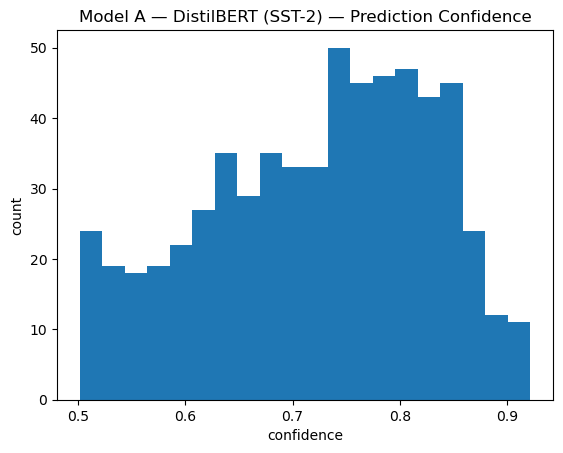

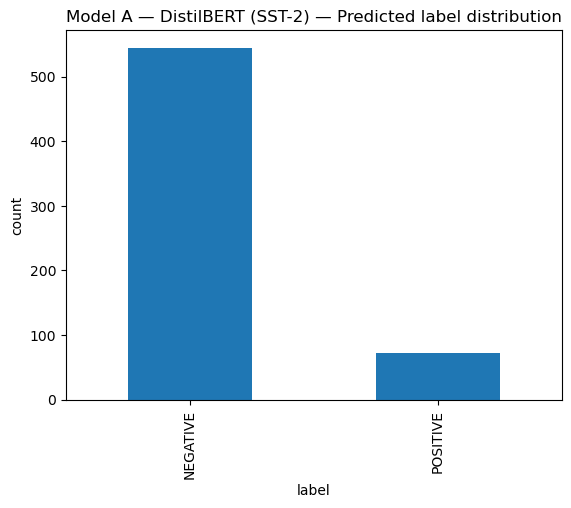

In [21]:
def evaluate_model(name: str, pipe):
    Y_pred, conf = predict_with_pipeline(list(X_test), pipe)
    acc = accuracy_score(Y_test, Y_pred)
    f1m = f1_score(Y_test, Y_pred, average="macro")
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f}\n")
    print(classification_report(Y_test, Y_pred, digits=4))
    print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(Y_test, Y_pred, labels=["NEGATIVE","NEUTRAL","POSITIVE"]))

    # Confidence histogram
    plt.figure()
    plt.hist(conf, bins=20)
    plt.title(f"{name} — Prediction Confidence")
    plt.xlabel("confidence")
    plt.ylabel("count")
    plt.show()

    # Predicted distribution
    pd.Series(Y_pred).value_counts().plot(kind="bar")
    plt.title(f"{name} — Predicted label distribution")
    plt.xlabel("label")
    plt.ylabel("count")
    plt.show()
    
    return {"name": name, "acc": acc, "f1_macro": f1m}

res_a = evaluate_model("Model A — DistilBERT (SST-2)", clf_a)

# Evaluate Second Model 

Evaluate and visualize **second model**.



=== Model B — Twitter RoBERTa (3-class) ===
Accuracy: 0.0000 | Macro-F1: 0.0000

              precision    recall  f1-score   support

     LABEL_1     0.0000    0.0000    0.0000       0.0
    NEGATIVE     0.0000    0.0000    0.0000      18.0
     NEUTRAL     0.0000    0.0000    0.0000     548.0
    POSITIVE     0.0000    0.0000    0.0000      51.0

    accuracy                         0.0000     617.0
   macro avg     0.0000    0.0000    0.0000     617.0
weighted avg     0.0000    0.0000    0.0000     617.0

Confusion matrix (rows=true, cols=pred):
 [[0 0 0]
 [0 0 0]
 [0 0 0]]


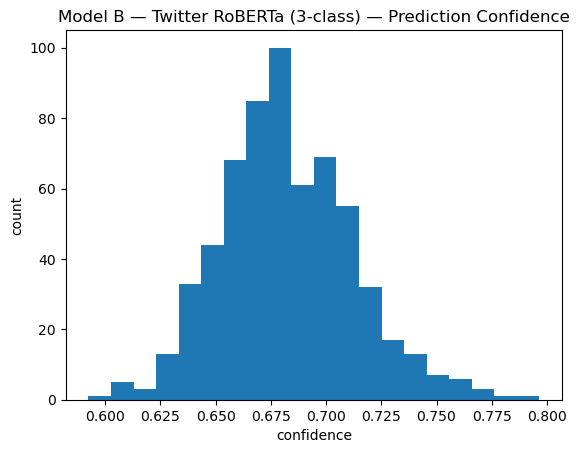

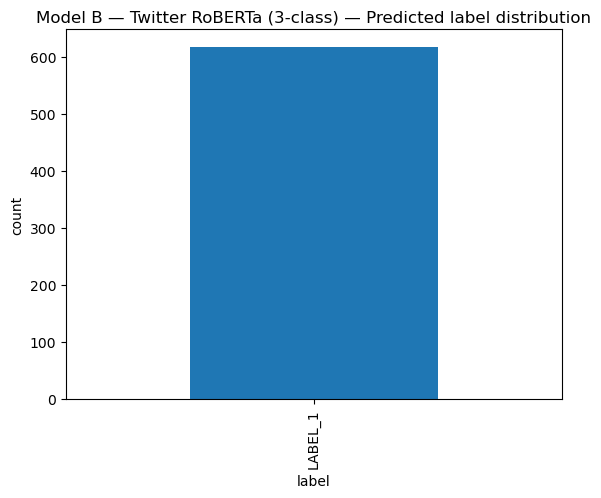

In [27]:
res_b = evaluate_model("Model B — Twitter RoBERTa (3-class)", clf_b)

# Compare Model Metrics: Accuracy and F1 Macro

In [23]:
comp = pd.DataFrame([res_a, res_b]).sort_values("f1_macro", ascending=False).reset_index(drop=True)
print("\nComparison (higher is better):")
display(comp)


Comparison (higher is better):


,name,acc,f1_macro
0,Model A — DistilBERT (SST-2),0.029173,0.042494
1,Model B — Twitter RoBERTa (3-class),0.000000,0.000000


# Reusable Prediction Function + Simple Reasoning

**Comment for this Markdown cell:** Provide a **reusable function** to predict on **any list of texts** with either model.  
For **reasoning**: we print the model confidence and highlight whether the text contains simple **sentiment cue words** (a tiny lexicon). This is not true model explainability, but it offers an understandable rationale for beginners.


In [24]:
POS_CUES = {"love","great","good","happy","joy","win","awesome","wonderful","amazing","like"}
NEG_CUES = {"hate","bad","sad","angry","annoyed","worry","worried","terrible","awful","disgust"}

def explain_basic(text: str):
    t = clean_text(text)
    pos_hits = sorted({w for w in POS_CUES if re.search(rf"\\b{re.escape(w)}\\b", t)})
    neg_hits = sorted({w for w in NEG_CUES if re.search(rf"\\b{re.escape(w)}\\b", t)})
    return pos_hits, neg_hits

def predict_texts(texts, model="a"):
    pipe = clf_a if str(model).lower().startswith("a") else clf_b
    preds, confs = predict_with_pipeline([clean_text(t) for t in texts], pipe)
    rows = []
    for text, label, conf in zip(texts, preds, confs):
        pos_hits, neg_hits = explain_basic(text)
        why = []
        why.append(f"model confidence={conf:.3f}")
        if pos_hits: why.append(f"positive cues: {pos_hits}")
        if neg_hits: why.append(f"negative cues: {neg_hits}")
        rows.append({"text": text, "pred": label, "confidence": conf, "why_simple": "; ".join(why)})
    return pd.DataFrame(rows)

# Demo (feel free to edit)
demo_df = predict_texts([
    "I love this new album so much!",
    "This is bad and I'm really angry about it.",
    "It's okay, nothing special."
], model="b")

display(demo_df)


,text,pred,confidence,why_simple
0,I love this new album so much!,LABEL_2,0.990959,model confidence=0.991
1,This is bad and I'm really angry about it.,LABEL_0,0.978269,model confidence=0.978
2,"It's okay, nothing special.",LABEL_2,0.629542,model confidence=0.630


# Creative Application (Your Data!)

**Comment for this Markdown cell:** Apply a chosen model to **your own domain** (e.g., song lyrics, news headlines).  
Below are two examples:

1. A **hardcoded list** (quick demo)
2. Loading from a CSV with a column called `text` (edit path/column for your file)


In [25]:
# Example 1: hardcoded list
my_domain_texts = [
    "Breaking: Markets rally as inflation cools to 2.5%.",
    "Lyrics: I'm feeling good, like I should.",
    "Match report: The team suffers a terrible defeat."
]
creative_results = predict_texts(my_domain_texts, model="b")
display(creative_results)

# Example 2: from a CSV file you provide (uncomment and set your file path)
# custom_df = pd.read_csv("/path/to/your_data.csv")
# creative_results2 = predict_texts(custom_df["text"].astype(str).tolist(), model="b")
# display(creative_results2.head(20))

,text,pred,confidence,why_simple
0,Breaking: Markets rally as inflation cools to ...,LABEL_2,0.580998,model confidence=0.581
1,"Lyrics: I'm feeling good, like I should.",LABEL_2,0.950357,model confidence=0.950
2,Match report: The team suffers a terrible defeat.,LABEL_0,0.946078,model confidence=0.946


# BONUS: Fine-Tuning Template (Optional)

**Comment for this Markdown cell:** (Optional) Template for **fine-tuning** a sentiment model with Hugging Face.  
This is a **skeleton** — you must adapt it to your labels and ensure you have enough data.

> Running this section can take time and requires a GPU for best results.


In [26]:
# # Prepare a Dataset object
# train_df = pd.DataFrame({"text": X_train, "label": pd.Categorical(y_train).codes})
# test_df  = pd.DataFrame({"text": X_test,  "label": pd.Categorical(y_test).codes})
# label_names = list(pd.Categorical(df['target']).categories)
# label2id = {name:i for i,name in enumerate(label_names)}
# id2label = {i:name for name,i in label2id.items()}

# ds_train = Dataset.from_pandas(train_df)
# ds_test  = Dataset.from_pandas(test_df)

# def tok_fn(batch):
#     return tokenizer(batch["text"], truncation=True)
# ds_train = ds_train.map(tok_fn, batched=True)
# ds_test  = ds_test.map(tok_fn, batched=True)

# collator = DataCollatorWithPadding(tokenizer=tokenizer)

# model = AutoModelForSequenceClassification.from_pretrained(
#     base_model_id, num_labels=len(label_names), id2label=id2label, label2id=label2id
# )

# args = TrainingArguments(
#     output_dir="./sentiment_ft",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=2,
#     weight_decay=0.01,
#     logging_steps=50
# )

# trainer = Trainer(
#     model=model,
#     args=args,
#     train_dataset=ds_train,
#     eval_dataset=ds_test,
#     tokenizer=tokenizer,
#     data_collator=collator,
# )

# trainer.train()
# trainer.evaluate()


# Conclusion

**What we accomplished:**

- Built a complete **sentiment analysis** workflow with two pretrained models.
- Evaluated with **accuracy, macro-F1**, and confusion matrices.
- Visualized **confidence** and **label distributions**.
- Created a reusable **prediction function** and applied it to a new domain.
- (Bonus) Prepared a **fine-tuning template** for domain adaptation.

**Next steps:**

- Collect more domain-specific labeled data and try the fine-tuning section.
- Explore more models in the Hugging Face Hub (larger RoBERTa/BERT variants).
- Add true explainability (e.g., SHAP, LIME) once you are comfortable with the basics.
